In [1]:
import csv
import re
from collections import defaultdict
from pprint import pformat

import altair as alt
import pandas as pd
import trueskill
from apiclient.discovery import build
from prettytable import PrettyTable
from getpass import getpass

### Read in CSV Data

In [2]:
with open('Game Grumps VS data.csv') as csv_file:
    csv_data = [line for line in csv.reader(csv_file)]
    
    csv_df = pd.DataFrame(csv_data[1:], columns=csv_data[0])

In [3]:
vs_df = csv_df.copy()
vs_df['Loser(s)'] = vs_df['Loser(s)'].map(lambda s: [loser.strip() for loser in s.split(';')])
vs_df['Competitors'] = (vs_df['Loser(s)'] + vs_df['Winner'].map(lambda s: [s])).map(lambda l: sorted(l))
vs_df['Genres'] = vs_df['Genres'].map(lambda s: [genre.strip() if genre else 'Unidentified' for genre in s.split(';')])
print(f"Game genres: { pformat({genre for genre_list in vs_df['Genres'] for genre in genre_list}) }")

Game genres: {'Arcade',
 'Board Game',
 'FPS',
 'Fighting',
 'Gameshow',
 'Puzzle',
 'Racing',
 'Sports',
 'Trivia',
 'Unidentified'}


#### Add Youtube Data

In [4]:
YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'
api_key = getpass('Youtube API Key')
youtube_client = build(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, developerKey=api_key)

Youtube API Key ·······································


In [5]:
vs_df['Youtube Data'] = vs_df['Episode-Id'].map(
    lambda episode_id: youtube_client.videos().list(part='snippet,contentDetails,statistics', id=episode_id).execute()['items'][0]
)

In [6]:
def duration_to_seconds(duration_string):
    pattern = re.compile('^PT(\d*H)?(\d*M)?(\d*S)?$')
    hours, minutes, seconds = pattern.match(duration_string).group(1, 2, 3)
    hours = int(hours[:-1] if hours else 0)
    minutes = int(minutes[:-1] if minutes else 0)
    seconds = int(seconds[:-1] if seconds else 0)
    return 3600 * hours + 60 * minutes + seconds

In [7]:
vs_df['Publish Date'] = pd.to_datetime(vs_df['Youtube Data'].map(lambda data: data['snippet']['publishedAt']), format='%Y-%m-%dT%H:%M:%SZ')
vs_df['Duration'] = vs_df['Youtube Data'].map(lambda data: duration_to_seconds(data['contentDetails']['duration']))
vs_df['Views'] = vs_df['Youtube Data'].map(lambda data: int(data['statistics']['viewCount']))
vs_df['Likes'] = vs_df['Youtube Data'].map(lambda data: int(data['statistics']['likeCount']))
vs_df['Dislikes'] = vs_df['Youtube Data'].map(lambda data: int(data['statistics']['dislikeCount']))
vs_df['Comments'] = vs_df['Youtube Data'].map(lambda data: int(data['statistics']['commentCount']))
vs_df = vs_df.sort_values(by='Publish Date').reset_index(drop=True)

#### Add Match Numbers

In [8]:
vs_df['Overall Match Number'] = vs_df.index + 1

In [9]:
vs_df = vs_df.join(
    vs_df.groupby(['Game', 'Episode-Id']).first()['Overall Match Number'].rename('First Game Match'),
    on=['Game', 'Episode-Id']
)
vs_df['Match Number'] = vs_df['Overall Match Number'] - vs_df['First Game Match'] + 1
vs_df = vs_df.drop(labels='First Game Match', axis=1)

In [10]:
def handle_first_place(winner):
    if 'Tie' in winner:
        return winner[winner.index('(')+1:-1].split('; ')
    if 'AI' in winner:
        return ['AI']
    return [winner]
def handle_second_place(winner):
    # If the AI wins we mark it as rank 0 (the best), the human that was was closest to first as rank 1
    # and all other humans as rank 2
    return winner[:-1].split('(')[1:] if 'AI' in winner else []
def handle_last_place(losers, second_place):
    return [loser for loser in losers if loser and loser not in second_place]
vs_df['First Place'] = vs_df['Winner'].map(handle_first_place)
vs_df['Second Place'] = vs_df['Winner'].map(handle_second_place)
vs_df['Last Place'] = vs_df.apply(lambda row: handle_last_place(losers=row['Loser(s)'], second_place=row['Second Place']), axis=1)

In [11]:
vs_df

,Winner,Loser(s),Game,Genres,Episode-Id,Notes,Competitors,Youtube Data,Publish Date,Duration,Views,Likes,Dislikes,Comments,Overall Match Number,Match Number,First Place,Second Place,Last Place
0,Jon,[Arin],Super Smash Bros. Brawl,[Fighting],uiofcRg6XEo,Arin is red,"[Arin, Jon]","{'kind': 'youtube#video', 'etag': 'beXXgyTgyuu...",2012-08-23 01:44:05,2697,3992398,43375,1434,25777,1,1,[Jon],[],[Arin]
1,Arin,[Jon],Super Smash Bros. Brawl,[Fighting],uiofcRg6XEo,,"[Arin, Jon]","{'kind': 'youtube#video', 'etag': 'beXXgyTgyuu...",2012-08-23 01:44:05,2697,3992398,43375,1434,25777,2,2,[Arin],[],[Jon]
2,Jon,[Arin],Super Smash Bros. Brawl,[Fighting],uiofcRg6XEo,,"[Arin, Jon]","{'kind': 'youtube#video', 'etag': 'beXXgyTgyuu...",2012-08-23 01:44:05,2697,3992398,43375,1434,25777,3,3,[Jon],[],[Arin]
3,Arin,[Jon],Super Smash Bros. Brawl,[Fighting],uiofcRg6XEo,,"[Arin, Jon]","{'kind': 'youtube#video', 'etag': 'beXXgyTgyuu...",2012-08-23 01:44:05,2697,3992398,43375,1434,25777,4,4,[Arin],[],[Jon]
4,Arin,[Jon],Super Smash Bros. Brawl,[Fighting],uiofcRg6XEo,,"[Arin, Jon]","{'kind': 'youtube#video', 'etag': 'beXXgyTgyuu...",2012-08-23 01:44:05,2697,3992398,43375,1434,25777,5,5,[Arin],[],[Jon]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,Tie (Arin; Danny),[],Mario Golf: Toadstool Tour,[Sports],wRPKjKG4KKo,,"[, Tie (Arin; Danny)]","{'kind': 'youtube#video', 'etag': '2jE_NHHEsba...",2015-06-01 21:00:01,868,620076,11225,185,1018,159,1,"[Arin, Danny]",[],[]
159,Danny,[Arin],Millionaire,"[Trivia, Gameshow]",cFurtZ7Gvb4,,"[Arin, Danny]","{'kind': 'youtube#video', 'etag': 'QaZtWGZCGHB...",2016-02-05 22:00:00,721,987003,22358,282,1492,160,1,[Danny],[],[Arin]
160,Arin,"[Danny, Jacob Anderson]",Wheel of Fortune,[Gameshow],90lejF5TzGM,,"[Arin, Danny, Jacob Anderson]","{'kind': 'youtube#video', 'etag': '644ZeKEM8QV...",2016-04-25 17:00:00,2873,3876538,66662,630,6223,161,1,[Arin],[],"[Danny, Jacob Anderson]"
161,Arin,"[Danny, Finn Wolfhard]",Wheel of Fortune,[Gameshow],fg_QS2yAsfI,,"[Arin, Danny, Finn Wolfhard]","{'kind': 'youtube#video', 'etag': 'vrVapR-SRAL...",2017-01-15 22:00:01,1696,2628531,75709,1207,8804,162,1,[Arin],[],"[Danny, Finn Wolfhard]"


### Overview Stats

In [12]:
all_competitors = sorted(
    filter(
        lambda item: item and '(' not in item,
        vs_df['Winner'].append(vs_df.explode('Loser(s)')['Loser(s)']).unique()
    )
)
print(f'All Competitors: {all_competitors}')

All Competitors: ['AI', 'Arin', 'Barry', 'Danny', 'Finn Wolfhard', 'Jacob Anderson', 'Jon', 'Ross', 'Susy']


In [13]:
competitor_data = {competitor: {'wins':0, 'games':0, 'won_vs':defaultdict(lambda: 0)} for competitor in all_competitors}
for i, match in vs_df.iterrows():
    winner = match['Winner']
    # TODO: add in ignoring AI in favor of top place human
    if 'AI' in winner:
        winner = 'AI'
    # TODO: Don't skip ties
    elif 'Tie' in winner:
        continue
    competitor_data[winner]['wins']+=1
    competitor_data[winner]['games']+=1
    for loser in match['Loser(s)']:
        competitor_data[loser]['games']+=1
        competitor_data[winner]['won_vs'][loser]+=1

In [14]:
MIN_MATCHES_FOR_DISPLAY = 3

filtered_competitors = [competitor for competitor in all_competitors if competitor_data[competitor]['games'] >= MIN_MATCHES_FOR_DISPLAY]
print(f'Competitors with at least {MIN_MATCHES_FOR_DISPLAY} matches: {filtered_competitors}')

Competitors with at least 3 matches: ['AI', 'Arin', 'Danny', 'Jon']


In [15]:
table = PrettyTable(['Competitor','Wins','Games Played', 'Win Rate'])
for competitor in filtered_competitors:
    data = competitor_data[competitor]
    win_rate = str(round(data['wins'] / data['games'] * 100, 2)) + '%'
    table.add_row([competitor, data['wins'], data['games'], win_rate])
print(table)

+------------+------+--------------+----------+
| Competitor | Wins | Games Played | Win Rate |
+------------+------+--------------+----------+
|     AI     |  14  |      30      |  46.67%  |
|    Arin    |  73  |     162      |  45.06%  |
|   Danny    |  4   |      15      |  26.67%  |
|    Jon     |  70  |     146      |  47.95%  |
+------------+------+--------------+----------+


In [16]:
table = PrettyTable(['vv Winner \ Loser ->'] + filtered_competitors)
for competitor in filtered_competitors:
    row = []
    for competitor_2 in filtered_competitors:
        if competitor == competitor_2:
            row.append('X')
        else:
            row.append(competitor_data[competitor]['won_vs'][competitor_2])
    table.add_row([competitor] + row)
print(table)

+----------------------+----+------+-------+-----+
| vv Winner \ Loser -> | AI | Arin | Danny | Jon |
+----------------------+----+------+-------+-----+
|          AI          | X  |  14  |   2   |  12 |
|         Arin         | 7  |  X   |   9   |  64 |
|        Danny         | 1  |  4   |   X   |  0  |
|         Jon          | 8  |  70  |   0   |  X  |
+----------------------+----+------+-------+-----+


In [17]:
table = PrettyTable(['vv Winner \ Loser ->'] + filtered_competitors)
for competitor in filtered_competitors:
    row = []
    for competitor_2 in filtered_competitors:
        if competitor == competitor_2:
            row.append('X')
        else:
            wins = competitor_data[competitor]['won_vs'][competitor_2]
            total = wins + competitor_data[competitor_2]['won_vs'][competitor]
            if total:
                row.append(str(round(wins / total * 100, 2)) + '%')
            else:
                row.append(0)
    table.add_row([competitor] + row)
print('___________Total Win Ratio Against Each Competitor__________') # TODO: Make this length programatic
print(table)

___________Total Win Ratio Against Each Competitor__________
+----------------------+--------+--------+--------+--------+
| vv Winner \ Loser -> |   AI   |  Arin  | Danny  |  Jon   |
+----------------------+--------+--------+--------+--------+
|          AI          |   X    | 66.67% | 66.67% | 60.0%  |
|         Arin         | 33.33% |   X    | 69.23% | 47.76% |
|        Danny         | 33.33% | 30.77% |   X    |   0    |
|         Jon          | 40.0%  | 52.24% |   0    |   X    |
+----------------------+--------+--------+--------+--------+


### TrueSkill Analysis

In [18]:
competitor_rankings = defaultdict(trueskill.Rating)
competitor_ranking_over_time = []

for _, match in vs_df.iterrows():
    competitors = (
        [[competitor_rankings[competitor]] for competitor in match['First Place']] + 
        [[competitor_rankings[competitor]] for competitor in match['Second Place']] + 
        [[competitor_rankings[competitor]] for competitor in match['Last Place']]
    )
    if match['Second Place']:
        rankings = (
            [0 for competitor in match['First Place']] + 
            [1 for competitor in match['Second Place']] + 
            [2 for competitor in match['Last Place']]
        )
    else:
        rankings = (
            [0 for competitor in match['First Place']] + 
            [1 for competitor in match['Last Place']]
        )
    # TODO: This should probably be a collections.deque since we work left to right
    match_result = trueskill.rate(competitors, rankings)
    # TODO: We can reformat this into a single loop through all competitors to reduce duplicate code
    for competitor in match['First Place']:
        updated_rating = match_result.pop(0)[0]
        competitor_rankings[competitor] = updated_rating
        competitor_ranking_over_time.append({
            'overall_match_number': match['Overall Match Number'],
            'match_publish_date': match['Publish Date'],
            'competitor': competitor,
            'mu': updated_rating.mu,
            'sigma': updated_rating.sigma,
            'incremental_winning_views': match['Views'],
            'incremental_losing_views': 0,
            'incremental_winning_seconds': match['Duration'],
            'incremental_losing_seconds': 0,
        })
    for competitor in match['Second Place']:
        updated_rating = match_result.pop(0)[0]
        competitor_rankings[competitor] = updated_rating
        # TODO: Figure out how to count second place views and seconds
        competitor_ranking_over_time.append({
            'overall_match_number': match['Overall Match Number'],
            'match_publish_date': match['Publish Date'],
            'competitor': competitor,
            'mu': updated_rating.mu,
            'sigma': updated_rating.sigma,
            'incremental_winning_views': match['Views'] // 2,
            'incremental_losing_views': match['Views'] // 2,
            'incremental_winning_seconds': match['Duration'] // 2,
            'incremental_losing_seconds': match['Duration'] // 2,
        })
    for competitor in match['Last Place']:
        updated_rating = match_result.pop(0)[0]
        competitor_rankings[competitor] = updated_rating
        competitor_ranking_over_time.append({
            'overall_match_number': match['Overall Match Number'],
            'match_publish_date': match['Publish Date'],
            'competitor': competitor,
            'mu': updated_rating.mu,
            'sigma': updated_rating.sigma,
            'incremental_winning_views': 0,
            'incremental_losing_views': match['Views'],
            'incremental_winning_seconds': 0,
            'incremental_losing_seconds': match['Duration'],
        })
    
competitor_ranking_over_time_df = pd.DataFrame(competitor_ranking_over_time)

In [19]:
table = PrettyTable(['Competitor', 'Final Skill Level'])
for competitor, rating in sorted(competitor_rankings.items()):
    table.add_row([competitor, round(rating.mu, 2)])
print(table)

+----------------+-------------------+
|   Competitor   | Final Skill Level |
+----------------+-------------------+
|       AI       |       26.46       |
|      Arin      |       25.15       |
|     Barry      |       30.82       |
|     Danny      |       23.55       |
| Finn Wolfhard  |       22.66       |
| Jacob Anderson |       22.78       |
|      Jon       |       24.72       |
|      Ross      |       24.04       |
|      Susy      |       24.04       |
+----------------+-------------------+


In [20]:
# Use this cell if you want to plot a pre-match starting point for trueskill
add_pre_start = True
if add_pre_start:
    first_comp_df = competitor_ranking_over_time_df.groupby('competitor').min()
    first_comp_df['competitor'] = first_comp_df.index
    first_comp_df['overall_match_number'] = first_comp_df['overall_match_number'] - 1
    starting_mu, starting_sigma = trueskill.Rating()
    first_comp_df['mu'] = starting_mu
    first_comp_df['sigma'] = starting_sigma
    competitor_ranking_over_time_df = competitor_ranking_over_time_df.append(
        first_comp_df
    ).sort_values(
        'overall_match_number'
    ).reset_index()
    competitor_ranking_over_time_df

In [21]:
relative_match_df = pd.DataFrame()
for competitor in filtered_competitors:
    comp_df = competitor_ranking_over_time_df[competitor_ranking_over_time_df['competitor'] == competitor].reset_index(drop=True)
    comp_df['competitor_match_number'] = comp_df.index + (0 if add_pre_start else 1)
    comp_df['days_since_first_match'] = (
        comp_df['match_publish_date'] - comp_df.iloc[0]['match_publish_date']
    ).map(lambda delta: delta.days)
    comp_df['winning_views'] = comp_df['incremental_winning_views'].cumsum()
    comp_df['losing_views'] = comp_df['incremental_losing_views'].cumsum()
    comp_df['winning_seconds'] = comp_df['incremental_winning_seconds'].cumsum()
    comp_df['losing_seconds'] = comp_df['incremental_losing_seconds'].cumsum()
    relative_match_df = relative_match_df.append(comp_df)
competitor_ranking_over_time_df = relative_match_df
competitor_ranking_over_time_df

,index,overall_match_number,match_publish_date,competitor,mu,sigma,incremental_winning_views,incremental_losing_views,incremental_winning_seconds,incremental_losing_seconds,competitor_match_number,days_since_first_match,winning_views,losing_views,winning_seconds,losing_seconds
0,AI,7,2012-08-27 21:21:06,AI,25.000000,8.333333,0,0,0,0,0,0,0,0,0,0
1,14,8,2012-08-27 21:21:06,AI,32.379987,6.067488,873891,0,1070,0,1,0,873891,0,1070,0
2,25,13,2012-09-02 01:11:06,AI,34.621035,5.181080,734549,0,898,0,2,5,1608440,0,1968,0
3,36,17,2012-09-05 01:19:06,AI,28.628166,3.773034,0,444694,0,653,3,8,1608440,444694,1968,653
4,37,18,2012-09-05 01:19:06,AI,30.271458,3.381142,444694,0,653,0,4,8,2053134,444694,2621,653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,306,142,2013-06-11 18:00:08,Jon,24.911103,0.792342,643191,0,1285,0,142,292,65941745,73602265,70968,74759
143,309,143,2013-06-11 18:00:08,Jon,24.814620,0.791970,0,643191,0,1285,143,292,65941745,74245456,70968,76044
144,310,144,2013-06-11 18:00:08,Jon,24.906159,0.791705,643191,0,1285,0,144,292,66584936,74245456,72253,76044
145,313,145,2013-06-11 18:00:08,Jon,24.809943,0.791350,0,643191,0,1285,145,292,66584936,74888647,72253,77329


In [22]:
color_order = list(competitor_ranking_over_time_df.groupby('competitor').min().sort_values('overall_match_number').index)

In [23]:
def make_trueskill_plot(x_axis_column, x_axis_label, x_axis_column_2=None, x_axis_label_2=None):
    #TODO: add option for interpolation, use 'basis'
    base = alt.Chart(competitor_ranking_over_time_df).encode(
        color=alt.Color('competitor', title='Competitor', sort=color_order, legend=alt.Legend(
            titleFontSize=14, labelFontSize=12, symbolSize=250
        )),
    )

    legend_selection = alt.selection_multi(fields=['competitor'], bind='legend')
    match_slider = alt.binding_range(
        min=1,
        max=competitor_ranking_over_time_df['overall_match_number'].max(),
        step=1,
        name='Final Match Number: '
    )
    match_selection = alt.selection_single(
        name="final_match_number",
        fields=['overall_match_number'],
        bind=match_slider,
        init={'overall_match_number':competitor_ranking_over_time_df['overall_match_number'].max()}
    )
    
    trueskill_plot = base.mark_line(strokeWidth=3).encode(
        y=alt.Y('mu', title='Skill Level', scale=alt.Scale(zero=False)),
        opacity=alt.condition(legend_selection, alt.value(1), alt.value(0.1))
    ) + base.mark_area().encode(
        y='y:Q',
        y2='y2:Q',
        fillOpacity=alt.condition(legend_selection, alt.value(0.3), alt.value(0.05))
    ).transform_calculate(
        y='datum.mu+datum.sigma',
        y2='datum.mu-datum.sigma'
    ).properties(
        width=800,
        height=250
    )

    upper_plot = trueskill_plot.encode(x=alt.X(x_axis_column, title=x_axis_label)).properties(title='Skill Level over Time')
    lower_plot = trueskill_plot.encode(x=alt.X(x_axis_column_2, title=x_axis_label_2))
    
    return (upper_plot & lower_plot).add_selection(
        legend_selection
    ).add_selection(
        match_selection
    ).transform_filter(
        alt.datum.overall_match_number <= match_selection.overall_match_number
    ).configure_title(fontSize=18)

In [24]:
make_trueskill_plot(
    x_axis_column='overall_match_number',
    x_axis_label='Overall Match Number',
    x_axis_column_2='match_publish_date', 
    x_axis_label_2 = 'Match Publish Date'
)

TypeError: sequence item 1: expected str instance, int found

In [25]:
make_trueskill_plot(
    x_axis_column='competitor_match_number',
    x_axis_label='Competitor Match Number',
    x_axis_column_2='days_since_first_match', 
    x_axis_label_2='Days Since First Match'
)

TypeError: sequence item 1: expected str instance, int found

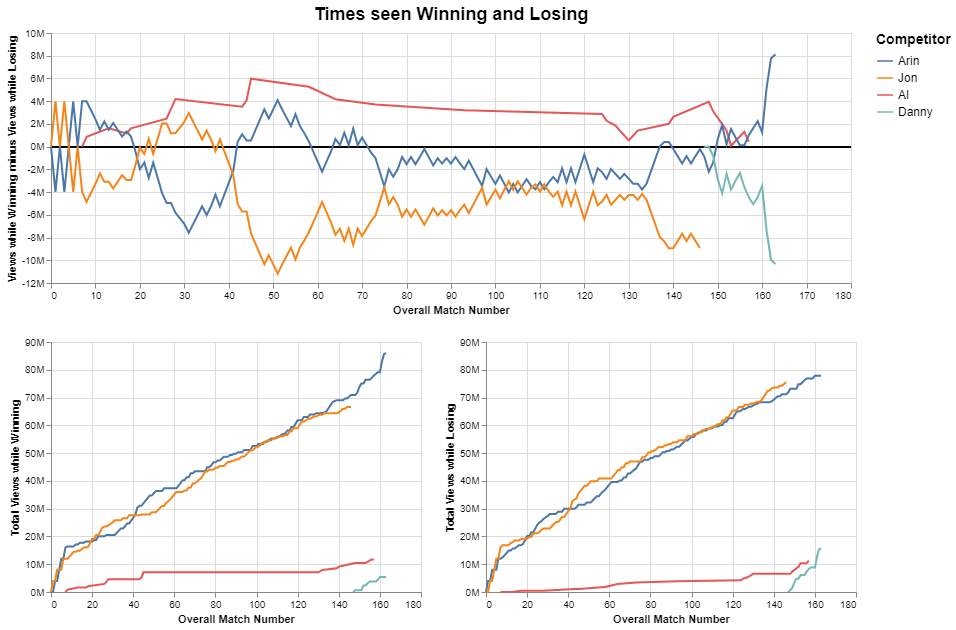

In [26]:
# TODO: clean up these plots and axes labels
# TODO: should the x-axis here be publish date and/or should we only have one datapoint per episode?
# TODO: add in selectors like above
# TODO: add text and points for final match for each competitor
# TODO: maybe add light area marks as well
(alt.Chart(
    competitor_ranking_over_time_df
).mark_rule().encode(
    y = 'zero:Q'
).transform_calculate(
    zero='0'
) + alt.Chart(competitor_ranking_over_time_df, title='Times seen Winning and Losing').mark_line().encode(
    x=alt.X('overall_match_number', title='Overall Match Number'),
    y=alt.Y('views_differential:Q', title='Views while Winning minus Views while Losing', axis=alt.Axis(format="~s")), # TODO: find better axis title
    color=alt.Color('competitor', title='Competitor', sort=color_order, legend=alt.Legend(
        titleFontSize=14, labelFontSize=12, symbolSize=250
    ))
).transform_calculate(
    views_differential='datum.winning_views - datum.losing_views'
).properties(width=800, height=250) & (alt.Chart(competitor_ranking_over_time_df).mark_line().encode(
    x=alt.X('overall_match_number', title='Overall Match Number'),
    y=alt.Y('winning_views', title='Total Views while Winning', axis=alt.Axis(format="~s")),
    color=alt.Color('competitor', title='Competitor', sort=color_order, legend=alt.Legend(
        titleFontSize=14, labelFontSize=12, symbolSize=250
    ))
).properties(width=370, height=250) | alt.Chart(competitor_ranking_over_time_df).mark_line().encode(
    x=alt.X('overall_match_number', title='Overall Match Number'),
    y=alt.Y('losing_views', title='Total Views while Losing', axis=alt.Axis(format="~s")),
    color=alt.Color('competitor', title='Competitor', sort=color_order, legend=alt.Legend(
        titleFontSize=14, labelFontSize=12, symbolSize=250
    ))
).properties(width=370, height=250)).resolve_scale(
    y='shared'
)).configure_title(fontSize=18)

In [27]:
# TODO: combine this and the above plot into a plotting function
# TODO: clean up these plots and axes labels
# TODO: should the x-axis here be publish date (maybe have both but focus on one) and/or should we only have one datapoint per episode?
# TODO: for this plot to make sense we should probably split episode length by the number of matches b/c this is biased currently
alt.Chart(competitor_ranking_over_time_df).mark_line().encode(
    x=alt.X('overall_match_number', title='Overall Match Number'),
    y='seconds_differential:Q',
    color='competitor'
).transform_calculate(
    seconds_differential='datum.winning_seconds - datum.losing_seconds'
).properties(width=800, height=250) & (alt.Chart(competitor_ranking_over_time_df).mark_line().encode(
    x=alt.X('overall_match_number', title='Overall Match Number'),
    y='winning_seconds',
    color='competitor'
).properties(width=360, height=250) | alt.Chart(competitor_ranking_over_time_df).mark_line().encode(
    x=alt.X('overall_match_number', title='Overall Match Number'),
    y='losing_seconds',
    color='competitor'
).properties(width=360, height=250))
pass # This plot is garbage so I don't want to render it